<a href="https://colab.research.google.com/github/fridapolanco/AI_Iowa_Retail_2024_Analysis/blob/main/5_IOWA_BLANCO_FORECAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IOWA RETAIL ANALYSIS**: 🍺 Retail in AI
#FORECASTING **BLANCO TEQUILA**

**TEAM:**

Frida Nicole Polanco Domínguez,

Nicole Herrera,

Alina Edigareva

[Inspo](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet)

##**SETTING UP NOTEBOOK**

In [ ]:
!pip install prophet

import prophet

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
plt.style.use('fivethirtyeight') # For plots

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_2021 = pd.read_csv("/content/drive/MyDrive/IOWA/2021_onwards_clean.csv") #Reading from clean CSV to avoid having to run all cleaning cells.

In [ ]:
df_2021['Date'] = pd.to_datetime(df_2021['Date'])
df_2021 = df_2021.set_index('Date')
df_2021.sort_index(inplace=True)

In [ ]:
df_2021.rename(columns={"Store Name": "store_name",
                        "Store Number": "store_number",
                        "Address": "address",
                        "City":"city",
                        "Zip Code":"zip",
                        "County":"county",
                        "Category Name":"category",
                        "Vendor Name":"vendor_name",
                        "Item Description":"item",
                        "Pack":"pack",
                        "Bottle Volume (ml)":"bottle_ml",
                        "State Bottle Cost":"cost",
                        "State Bottle Retail":"retail",
                        "Bottles Sold": "bottles_sold",
                        "Sale (Dollars)": "sale_usd",
                        "Volume Sold (Liters)": "sale_liters",
                        "Store Status": "store_status",
                        },
               inplace=True)

In [ ]:
#Creating a column with Tequila type - BLANCO, REPOSADO, AÑEJO, ROSADO, DORADO, FLAVORED

def tequila_type(item_column):
    item_column = str(item_column).lower()  # Handle potential NaN values and normalize case
    if any(keyword in item_column for keyword in["anejo","tears of llorona","sauza conmemorativo","black barrel","real","selection suprema","partida elegante",
                                                 "tres generaciones legacy edition","burdeos","piedra","extra aged","reserva 44","herradura legend","guerrero","eight reserve","marques de tequila",
                                                 "sol del sur tequila"]):
        return 'ANEJO'
    elif any(keyword in item_column for keyword in["reposado","1942","reposada","don julio 3x375ml","patron el alto","astral tequila"]):
        return 'REPOSADO'
    elif any(keyword in item_column for keyword in["rosa","rosado"]):
        return 'ROSADO'
    elif any(keyword in item_column for keyword in["blanco","silver","white","plateado","plata","cristalino","platinum","crystal","platino","70","70th",
                                                   "ghost tequila","cielo","diamante","diamond","codigo 1530 combo mini","padrecito","blue dream","siete leguas decadas","santo puro mezquila",
                                                   "astral tequila"]):
        return 'BLANCO'
    elif any(keyword in item_column for keyword in["gold","dorado","joven","libelula"]):
        return 'DORADO/JOVEN'
    elif any(keyword in item_column for keyword in["jalapeno","habanero","coconut","grapefruit","orange","infused","flavored","mango","strawberry","lime","berry","citrus",
                                                   "salted chocolate","vanilla","alma miel","cream","devils"]):
        return 'FLAVORED'
    else:
       return 'UNKNOWN'

df_2021['tequila_type'] = df_2021['item'].apply(tequila_type)

In [ ]:
df_2021['tequila_type'].value_counts()

,count
tequila_type,
UNKNOWN,8545817
FLAVORED,895864
BLANCO,549364
REPOSADO,254611
DORADO/JOVEN,115066
ANEJO,55226
ROSADO,1648


In [ ]:
#Filtering For BLANCO TEQUILA
blanco_df = df_2021[df_2021.tequila_type == "BLANCO"]

##**FORECAST**

In [ ]:
#Resampling to weekly granularity
datos = blanco_df["sale_usd"].resample("W").sum()

In [ ]:
datos.describe()

,sale_usd
count,209.000000
mean,538249.102249
std,107845.009544
min,231047.650000
25%,483490.990000
50%,535964.900000
75%,592994.060000
max,848364.340000


In [ ]:
#Splitting around 30% of the data to test
split_date = '01-Oct-2023'
train = datos.loc[datos.index <= split_date].copy()
test = datos.loc[datos.index > split_date].copy()

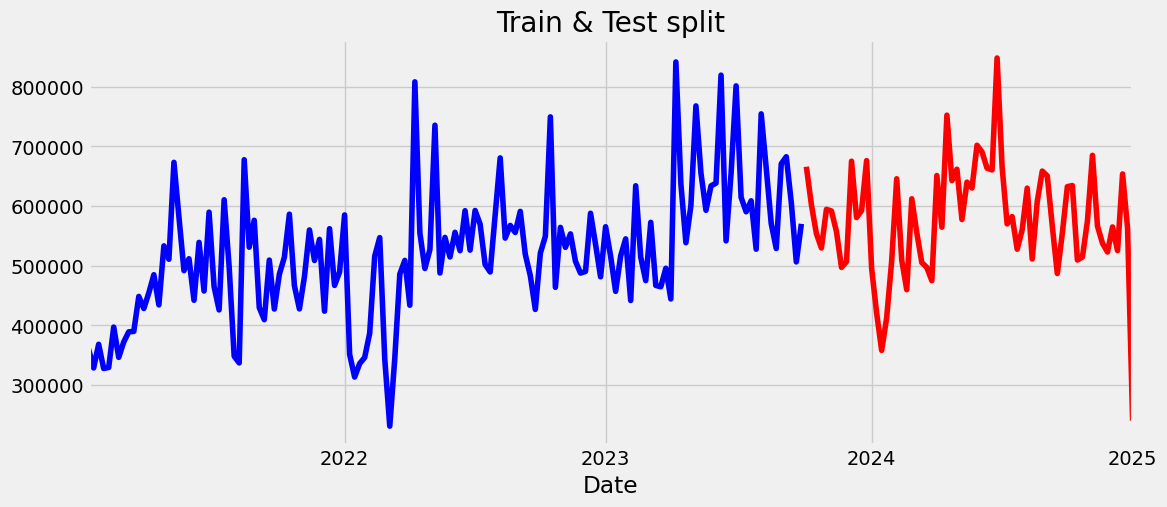

In [ ]:
train.plot(figsize=(12, 5), title="Train set", color="blue");
test.plot(figsize=(12, 5), title="Test set", color="red");
plt.title("Train & Test split")
plt.show()

In [ ]:
train.head()

,sale_usd
Date,
2021-01-10,360165.80
2021-01-17,328651.71
2021-01-24,368369.28
2021-01-31,327795.48
2021-02-07,329488.39


In [ ]:
#Format data to be as prophet needs it
train_prophet = train.reset_index().rename(columns={"Date":"ds","sale_usd":"y"})
test_prophet = test.reset_index().rename(columns={"Date":"ds","sale_usd":"y"})

In [ ]:
#Instantiate the model

from prophet import Prophet

model = Prophet(weekly_seasonality=True)
model.fit(train_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpahvxf07b/6rl0jd30.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpahvxf07b/pw3gb4o5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=878', 'data', 'file=/tmp/tmpahvxf07b/6rl0jd30.json', 'init=/tmp/tmpahvxf07b/pw3gb4o5.json', 'output', 'file=/tmp/tmpahvxf07b/prophet_modely39z2c5o/prophet_model-20250306140129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:01:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:01:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Testing
test_forecast = model.predict(test_prophet)

In [ ]:
#The results show all the components of the prediction. yhat, the last column, is the predicted one
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-10-08,559727.126507,549262.704113,728859.085050,559727.126507,559727.126507,81556.972193,81556.972193,81556.972193,52636.425289,52636.425289,52636.425289,28920.546905,28920.546905,28920.546905,0.0,0.0,0.0,641284.098700
1,2023-10-15,561000.979220,569563.072778,751563.990577,561000.482212,561001.267058,104145.049203,104145.049203,104145.049203,52636.425289,52636.425289,52636.425289,51508.623914,51508.623914,51508.623914,0.0,0.0,0.0,665146.028423
2,2023-10-22,562274.831933,559979.940744,742061.881328,562273.555438,562275.928507,86572.012498,86572.012498,86572.012498,52636.425289,52636.425289,52636.425289,33935.587209,33935.587209,33935.587209,0.0,0.0,0.0,648846.844430
3,2023-10-29,563548.684645,526267.982513,710130.414986,563546.303755,563551.015299,52298.254338,52298.254338,52298.254338,52636.425289,52636.425289,52636.425289,-338.170951,-338.170951,-338.170951,0.0,0.0,0.0,615846.938983
4,2023-11-05,564822.537358,510950.973131,690709.835531,564818.671773,564826.350420,34609.564318,34609.564318,34609.564318,52636.425289,52636.425289,52636.425289,-18026.860971,-18026.860971,-18026.860971,0.0,0.0,0.0,599432.101676


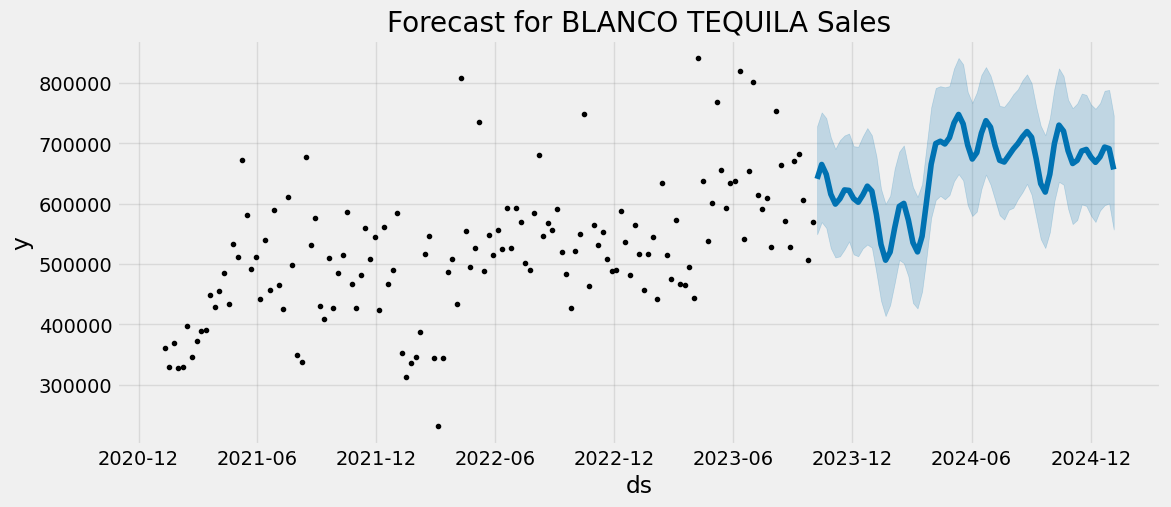

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(test_forecast, ax=ax)
ax.set_title("Forecast for BLANCO TEQUILA Sales")
plt.show()

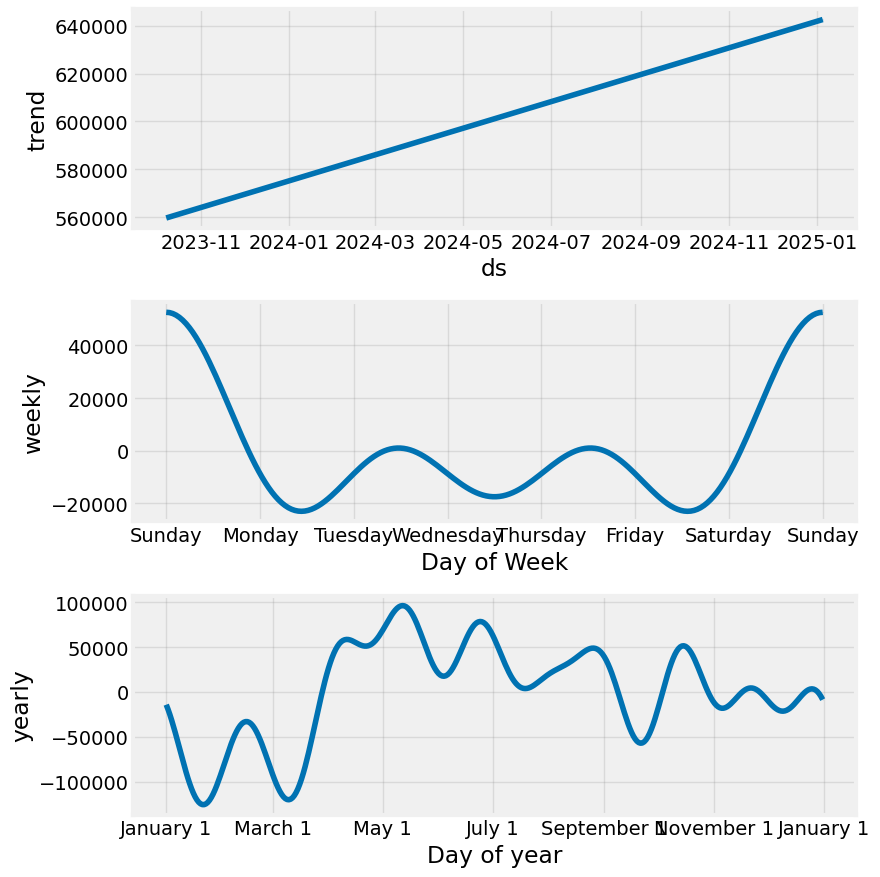

In [ ]:
#Checking seasonality trends
model.plot_components(test_forecast)
plt.show()

In [ ]:
test

,sale_usd
Date,
2023-10-08,666051.85
2023-10-15,602651.74
2023-10-22,553779.55
2023-10-29,529724.77
2023-11-05,594617.56
...,...
2024-12-08,565121.17
2024-12-15,525362.01
2024-12-22,653930.84


Text(0.5, 1.0, 'Forecast vs Actuals')

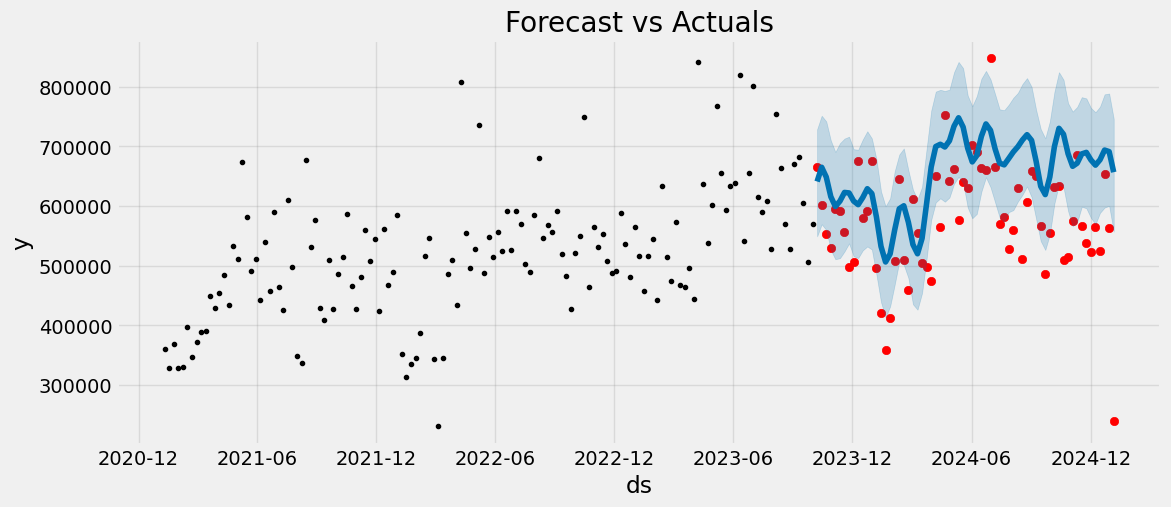

In [ ]:
#COMPARE FORECAST TO ACTUALS

f, ax = plt.subplots(figsize=(12, 5))
# Use test["sale_usd"] to get the actual sales data for the y-axis
ax.scatter(test.index, test_prophet["y"], color ="r")
fig = model.plot(test_forecast, ax=ax)
ax.set_title("Forecast vs Actuals")

#red = true, blue = forecast

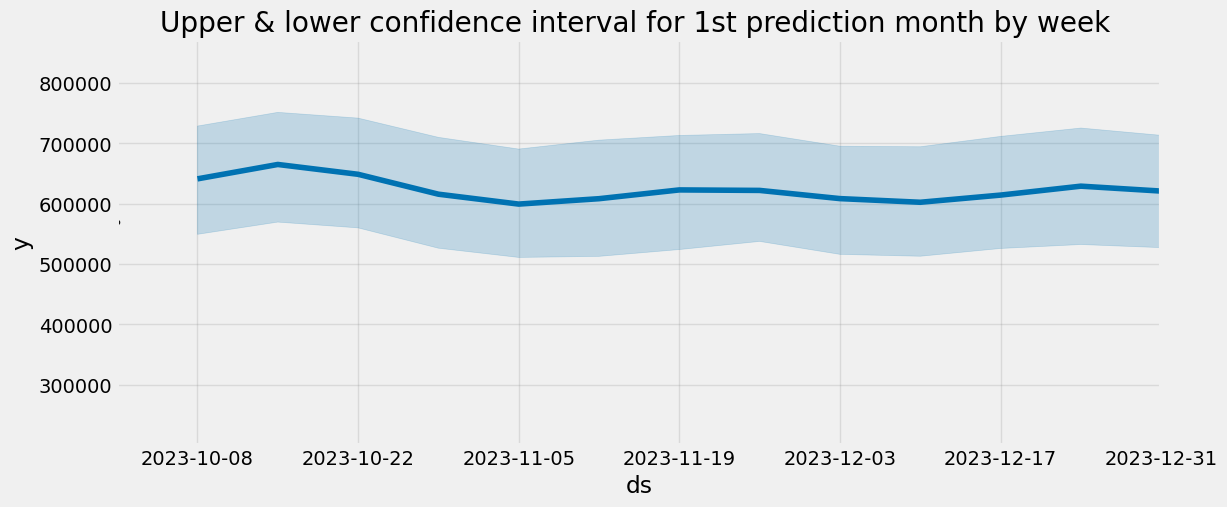

In [ ]:
#Comparing first 3 month of predictions

# Create a new figure and axes for this plot
fig, ax = plt.subplots(figsize=(12, 5))

fid = model.plot(test_forecast, ax=ax)
# Convert the date strings to pandas Timestamp objects
ax.set_xbound(lower=pd.Timestamp('2023-10-01'), upper=pd.Timestamp('2023-12-31'))
ax.set_title("Upper & lower confidence interval for 1st prediction month by week ")
plt.show()

In [ ]:
#Evaluating error metrics

np.sqrt(mean_squared_error(y_true=test_prophet["y"], y_pred=test_forecast["yhat"]))

112397.19586729594

In [ ]:
mean_absolute_error(y_true=test_prophet["y"], y_pred=test_forecast["yhat"])

93326.69755134605

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_true=test_prophet["y"], y_pred=test_forecast["yhat"])

0.18581198866202092

##**PREDICTIONS**

In [ ]:
#Predicting in the future

future = model.make_future_dataframe(periods=4*52, freq="W", include_history=False)
forecasted_sales = model.predict(future)

In [ ]:
forecasted_sales.ds.describe()

,ds
count,208
mean,2025-10-01 12:00:00
min,2023-10-08 00:00:00
25%,2024-10-04 06:00:00
50%,2025-10-01 12:00:00
75%,2026-09-28 18:00:00
max,2027-09-26 00:00:00


In [ ]:
forecasted_sales[["ds","yhat"]]

,ds,yhat
0,2023-10-08,641284.098700
1,2023-10-15,665146.028423
2,2023-10-22,648846.844430
3,2023-10-29,615846.938983
4,2023-11-05,599432.101676
...,...,...
203,2027-08-29,918030.710001
204,2027-09-05,895993.672977
205,2027-09-12,853756.870214
206,2027-09-19,820969.847291


In [ ]:
print(f"Total predicted sales for 2025 is {forecasted_sales[(forecasted_sales.ds > '2025-01-01') & (forecasted_sales.ds <= '2025-12-31')].yhat.sum()}")

Total predicted sales for 2025 is 37839856.91651828


In [ ]:
print(f"Total predicted sales for 2026 is {forecasted_sales[(forecasted_sales.ds > '2026-01-01') & (forecasted_sales.ds <= '2026-12-31')].yhat.sum()}")

Total predicted sales for 2026 is 41283351.14072751


In [ ]:
print(f"Total sales for 2024 were {forecasted_sales[(forecasted_sales.ds > '2024-01-01') & (forecasted_sales.ds <= '2024-12-31')].yhat.sum()}")

Total sales for 2024 were 34396547.95808089


**GRAPHING REAL & PREDICTED TOGETHER**

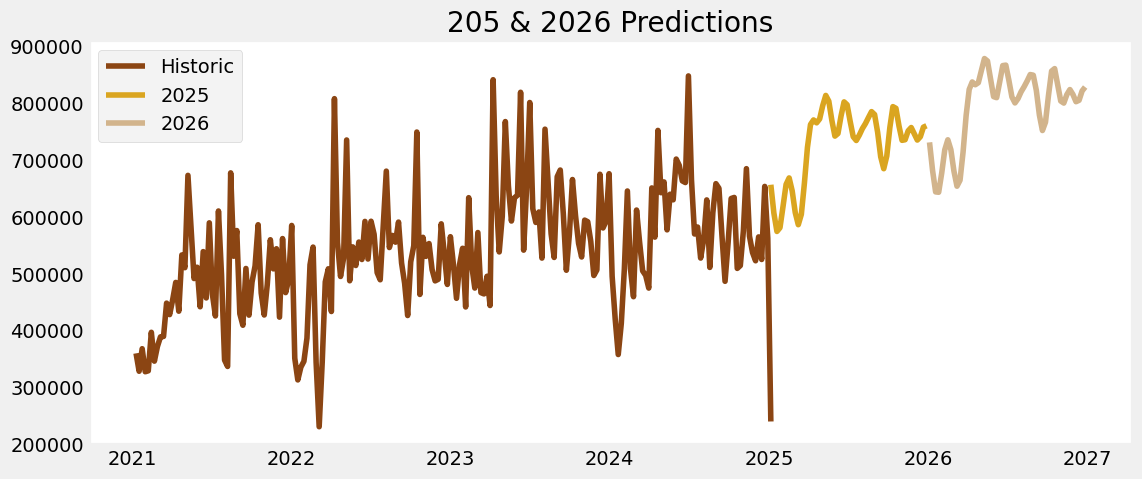

In [ ]:
real = datos.copy()
forecast_2025 = forecasted_sales[(forecasted_sales.ds > '2025-01-01') & (forecasted_sales.ds <= '2025-12-31')].set_index('ds')
forecast_2026 = forecasted_sales[(forecasted_sales.ds > '2026-01-01') & (forecasted_sales.ds <= '2026-12-31')].set_index('ds')

fig, ax = plt.subplots(figsize=(12, 5))
# Convert real.index to datetime objects if they are not already
real_index = pd.to_datetime(real.index, errors='coerce')

# Filter out any NaT (Not a Time) values that might have resulted from conversion errors
real_index = real_index[pd.notnull(real_index)]
real = real[real_index]

ax.plot(real_index, real, label='Historic', color='saddlebrown')
# Access the index and 'yhat' column using indexing
ax.plot(forecast_2025.index, forecast_2025['yhat'], label='2025', color='goldenrod')
ax.plot(forecast_2026.index, forecast_2026['yhat'], label='2026', color='tan')
plt.gca().set_facecolor("white")
ax.set_title("205 & 2026 Predictions")
ax.legend()
ax.grid(False)
plt.show() # Show the plot explicitly

In [ ]:
real

,sale_usd
Date,
2021-01-10,360165.80
2021-01-17,328651.71
2021-01-24,368369.28
2021-01-31,327795.48
2021-02-07,329488.39
...,...
2024-12-08,565121.17
2024-12-15,525362.01
2024-12-22,653930.84


In [ ]:
forecast_2025.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2025-01-05,642527.552830,566234.823724,747723.256924,642266.981702,642772.544531,14337.469300,14337.469300,14337.469300,52636.425289,52636.425289,52636.425289,-38298.955989,-38298.955989,-38298.955989,0.0,0.0,0.0,656865.022130
2025-01-12,643801.405543,514978.513071,697975.455390,643535.104842,644051.853152,-36874.916220,-36874.916220,-36874.916220,52636.425289,52636.425289,52636.425289,-89511.341509,-89511.341509,-89511.341509,0.0,0.0,0.0,606926.489323
2025-01-19,645075.258256,482204.771587,665002.431395,644800.054207,645333.012904,-70424.141501,-70424.141501,-70424.141501,52636.425289,52636.425289,52636.425289,-123060.566789,-123060.566789,-123060.566789,0.0,0.0,0.0,574651.116755
2025-01-26,646349.110968,484875.798513,671516.921052,646064.174407,646613.065428,-65087.910678,-65087.910678,-65087.910678,52636.425289,52636.425289,52636.425289,-117724.335967,-117724.335967,-117724.335967,0.0,0.0,0.0,581261.200290
2025-02-02,647622.963681,528506.678049,708242.368263,647332.739273,647890.670627,-28823.108890,-28823.108890,-28823.108890,52636.425289,52636.425289,52636.425289,-81459.534179,-81459.534179,-81459.534179,0.0,0.0,0.0,618799.854791


In [ ]:
forecast_2025 = forecast_2025.yhat

In [ ]:
forecast_2026 = forecast_2026.yhat
forecast_2026.head()

,yhat
ds,
2026-01-04,731467.097882
2026-01-11,681978.192851
2026-01-18,644294.061196
2026-01-25,643658.385603
2026-02-01,677492.547281


In [ ]:
forecast_2025 = forecast_2025.rename('sale_usd')  # Rename the series to 'sale_usd'
forecast_2026 = forecast_2026.rename('sale_usd')  # Rename the Series to 'sale_usd'

In [ ]:
forecast_2025.head()

,sale_usd
ds,
2025-01-05,656865.022130
2025-01-12,606926.489323
2025-01-19,574651.116755
2025-01-26,581261.200290
2025-02-02,618799.854791


In [ ]:
all = pd.concat([real, forecast_2025, forecast_2026], axis=0) # Changed pd.union to pd.concat and specified axis=0 to concatenate rows

In [ ]:
all.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 313 entries, 2021-01-10 to 2026-12-27
Series name: sale_usd
Non-Null Count  Dtype  
--------------  -----  
313 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


In [ ]:
all

,sale_usd
2021-01-10,360165.800000
2021-01-17,328651.710000
2021-01-24,368369.280000
2021-01-31,327795.480000
2021-02-07,329488.390000
...,...
2026-11-29,815689.426865
2026-12-06,802986.072300
2026-12-13,805486.817465
2026-12-20,821932.214030


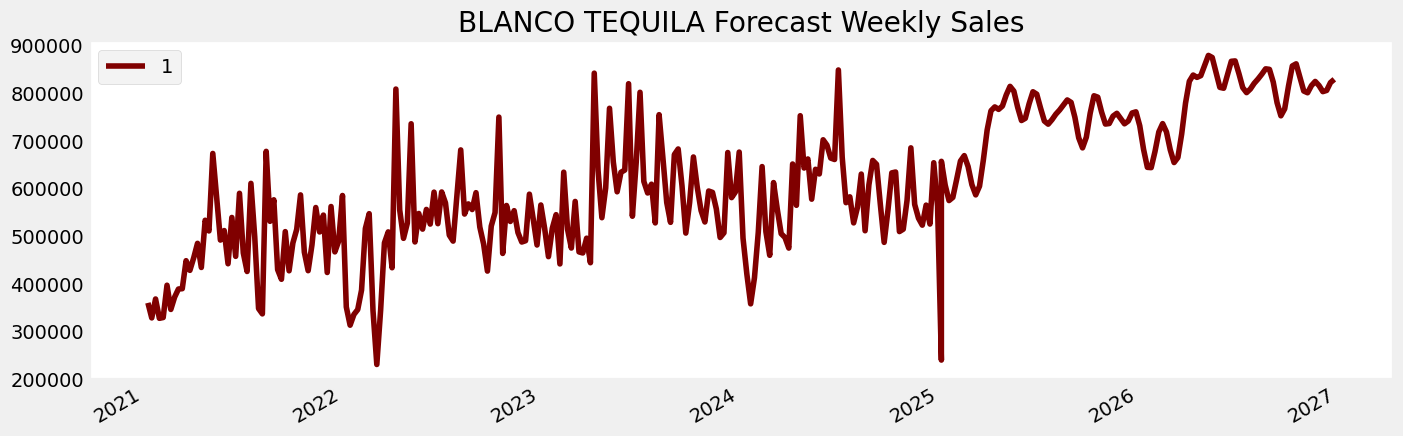

In [ ]:
all.plot(figsize=(15, 5), color="maroon")
plt.grid(False)
plt.gca().set_facecolor("white")
plt.title("BLANCO TEQUILA Forecast Weekly Sales")
plt.style.use('fivethirtyeight')
plt.legend("100% Agave")

plt.show()

##**METRICS ANALYSIS**

Your model's performance can be evaluated based on the following metrics:

* Mean Squared Error (MSE) = 118,893.55

This value represents the average squared difference between predicted and actual values. Since MSE is in squared units of the target variable, its magnitude is harder to interpret directly, but smaller values indicate better performance.

* Mean Absolute Error (MAE) = 95,397.72

This is the average absolute difference between predicted and actual values, meaning your model's predictions are, on average, about 95,398 off from the true values. Given that the mean sale value is $566,037, this suggests a moderate error.

* Mean Absolute Percentage Error (MAPE) = 0.1658 (~16.58%)

This means your model's predictions, on average, deviate by about 16.58% from the actual values. Generally, a MAPE below 10% is considered very good, 10-20% is acceptable depending on the industry, and above 20% is often considered poor.


----

Relative to the mean sale value (566,037), an MAE of $95,398 suggests that your model is making predictions with a reasonable but non-negligible margin of error.

A MAPE of 16.58% suggests that your model is moderately accurate. It may be acceptable depending on the industry standard, but there is room for improvement.

If prediction errors significantly impact decisions (e.g., financial forecasting), then a lower MAE and MAPE would be preferable.